In [1]:
using LinearAlgebra
using Test

import Base.*, Base.\, LinearAlgebra.lu

# Pasovne diagonalno dominantne matrike

Da se prihrani prostor je tip PasovnaMatrika definiran tako da so shranjene samo neničelni pasovi matrike. To je narejeno tako da ima vsak pas nek indeks:
- diagonala: 0
- pod diagonalo: -1, -2, ...
- nad diagonalo: 1, 2, ...

Vsak indeks določa neničelen pas matrike, ki je predstavljen z vektorjem. Pas i določa vektor dolžine n - abs(i), kjer je n velikost matrike.

Za pasovne matrike je implementirano množenje, deljenje in lu razcep, kjer se operacije dela samo na neničelnih pasovih, kar je hitreje kakor če bi se šlo čez celo matriko.

Pri deljenju pasovne matrike se najprej naredi eliminacija, nato pa vstavljanje. Pri Zgornje- in Spodnje- pasovnih matrikah se izračuna samo vstavljanje.

Za LU razcep najprej definiramo spodnje trikotno L matriko s samo enkami na diagonali. Potem izračunamo razcep na kopiji vhodne matrike in zapolnimo L matriko, na koncu pa definiramo še U matriko kot zgornji del spremenjene vhodne matrike.

In [2]:
"""
    PasovnaMatrika{T}(pasovi, n)

Matrika ki ima le nekaj neničelnih pasov
Attributes:
n - velikost matrike
pasovi - Dict{Int, Vector{T}}, kjer so keyi ... -2, -1, 0, 1, 2 ..., oz tisti pasovi ki vsebujejo neničelne vrednosti, 
            negativne vrednosti označujejo pasove pod diagonalo, 0 je pas diagonale in pozitivni so pasovi nad diagonalo

Primer:
PasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (-1, [5, 6, 7]), (1, [8, 9, 10]), (2, [11, 12])]), 4)
describes matrix [1 8 11 0; 5 2 9 12; 0 6 3 10; 0 0 7 4]

Definicija z uporabo zanke:
pasoviA = Dict{Int64, Vector{Float64}}(i => zeros(n*m-abs(i)) for i=-2n:2n)
A = PasovnaMatrika(pasoviA, n*m)
"""
struct PasovnaMatrika{T} <: AbstractArray{T, 2}
    pasovi::Dict{Int, Vector{T}} # 0 diagonala, 1, 2, 3...nad diagonalo, -1, -2, ... pod diagonalo
    n::Int
end

"""
    ZgornjePasovnaMatrika{T}(pasovi, n)

Matrika ki ima nekaj neničelnih pasov nad diagonalo
Attributes:
n - velikost matrike
pasovi - Dict{Int, Vector{T}}, kjer so keyi 0, 1, 2 ..., oz tisti pasovi ki vsebujejo neničelne vrednosti, 
            0 je pas diagonale, pozitivni so pasovi nad diagonalo

Primer:
PasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (1, [8, 9, 10]), (2, [11, 12])]), 4)
describes matrix [1 8 11 0; 0 2 9 12; 0 0 3 10; 0 0 0 4]
"""
struct ZgornjePasovnaMatrika{T} <: AbstractArray{T, 2}
    pasovi::Dict{Int, Vector{T}} 
    n::Int
end

"""
    SpodnjePasovnaMatrika{T}(pasovi, n)

Matrika ki ima nekaj neničelnih pasov pod diagonalo
Attributes:
n - velikost matrike
pasovi - Dict{Int, Vector{T}}, kjer so keyi ... -2, -1, 0, oz tisti pasovi ki vsebujejo neničelne vrednosti, 
            negativne vrednosti označujejo pasove pod diagonalo, 0 je pas diagonale 

Primer:
PasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (-1, [5, 6, 7])]), 4)
describes matrix [1 0 0 0; 5 2 0 0; 0 6 3 0; 0 0 7 4]
"""
struct SpodnjePasovnaMatrika{T} <: AbstractArray{T, 2}
    pasovi::Dict{Int, Vector{T}} 
    n::Int
end

SpodnjePasovnaMatrika

In [3]:
"""
    size(M)

Vrne velikost pasovne matrike M
"""
function Base.size(M::PasovnaMatrika)
    return (M.n, M.n)
end

"""
    size(M)

Vrne velikost zgornje pasovne matrike M
"""
function Base.size(M::ZgornjePasovnaMatrika)
    return (M.n, M.n)
end

"""
    size(M)

Vrne velikost spodnje pasovne matrike M
"""
function Base.size(M::SpodnjePasovnaMatrika)
    return (M.n, M.n)
end

Base.size

In [4]:
"""
    getindex(M, I(2))

Vrne element pasovne matrike na mestu I
"""
function Base.getindex(M::PasovnaMatrika, I::Vararg{Int, 2})
    pas = I[2] - I[1]
    if haskey(M.pasovi, pas)
        if pas >= 0
            return M.pasovi[pas][I[1]]
        else 
            return M.pasovi[pas][I[2]]
        end
    else
        return 0
    end
end

"""
    getindex(M, I(2))

Vrne element zgornje pasovne matrike na mestu I
"""
function Base.getindex(M::ZgornjePasovnaMatrika, I::Vararg{Int, 2})
    pas = I[2] - I[1]
    if haskey(M.pasovi, pas)
        return M.pasovi[pas][I[1]]
    else
        return 0
    end
end

"""
    getindex(M, I(2))

Vrne element spodnje pasovne matrike na mestu I
"""
function Base.getindex(M::SpodnjePasovnaMatrika, I::Vararg{Int, 2})
    pas = I[2] - I[1] 
    if haskey(M.pasovi, pas)
        return M.pasovi[pas][I[2]]
    else
        return 0
    end
end

Base.getindex

In [5]:
"""
    setindex(M, v, I(2))

Nastavi element na mestu I na vrednost v
Vrne napako če spreminjamo vrednosti v ničelih pasovih
"""
function Base.setindex!(M::PasovnaMatrika, v, I::Vararg{Int, 2})
    pas = I[2] - I[1]
    if haskey(M.pasovi, pas)
        if pas >= 0
            M.pasovi[pas][I[1]] = v
        else 
            M.pasovi[pas][I[2]] = v
        end
    else
        return error("Vrednosti se lahko nastavi samo v neničelnih pasovih") # dodaj cel pas naenkrat? -> setindex!(A, X, I...)
    end
end

"""
    setindex(M, v, I(2))

Nastavi element na mestu I na vrednost v
Vrne napako če spreminjamo vrednosti v ničelih pasovih
"""
function Base.setindex!(M::SpodnjePasovnaMatrika, v, I::Vararg{Int, 2})
    pas = I[2] - I[1]
    if haskey(M.pasovi, pas)
        M.pasovi[pas][I[2]] = v
    else
        return error("Vrednosti se lahko nastavi samo v neničelnih pasovih") 
    end
end

"""
    setindex(M, v, I(2))

Nastavi element na mestu I na vrednost v
Vrne napako če spreminjamo vrednosti v ničelih pasovih
"""
function Base.setindex!(M::ZgornjePasovnaMatrika, v, I::Vararg{Int, 2})
    pas = I[2] - I[1]
    if haskey(M.pasovi, pas)
        M.pasovi[pas][I[1]] = v
    else
        return error("Vrednosti se lahko nastavi samo v neničelnih pasovih") 
    end
end

Base.setindex!

In [6]:
"""
    M*v

Zmnoži pasovno matriko M z vektorjem v
"""
function *(M::PasovnaMatrika, v::Vector)
    y = zeros(length(v))
    for (k, pas) in M.pasovi
        for i=1:length(pas)
            row = k<=0 ? -k+i : i # indeks elemneta v pasu
            col = k<=0 ? i : k+i # indeks elemnta v pasu
            y[row] += v[col] * pas[i]
        end
    end
    return y
end

"""
    M*v

Zmnoži tgornje pasovno matriko M z vektorjem v
"""
function *(M::ZgornjePasovnaMatrika, v::Vector)
    y = zeros(length(v))
    for (k, pas) in M.pasovi
        for i=1:length(pas)
            row = i # indeks elemneta v pasu
            col = k+i # indeks elemnta v pasu
            y[row] += v[col] * pas[i]
        end
    end
    return y
end

"""
    M*v

Zmnoži spodnje pasovno matriko M z vektorjem v
"""
function *(M::SpodnjePasovnaMatrika, v::Vector)
    y = zeros(length(v))
    for (k, pas) in M.pasovi
        for i=1:length(pas)
            row = -k+i # indeks elemneta v pasu
            col = i # indeks elemnta v pasu
            y[row] += v[col] * pas[i]
        end
    end
    return y
end

Base.:*

In [7]:
"""
    M\\b

Izračuna rešitev sistema Mx=b za pasovno matriko M
Podana matrika in vektor morata biti tipa Float
"""
function \(M_in::PasovnaMatrika, b::Vector)
    bc = deepcopy(b)
    M = PasovnaMatrika(deepcopy(M_in.pasovi), M_in.n)
    z_pas = maximum(keys(M_in.pasovi))
    l_pas = minimum(keys(M_in.pasovi))

    for j=1:M.n
        for i=j+1:min(M.n, -l_pas+j)
            l = M[i, j] / M[j, j]
            M[i, j] = 0
            for k=j+1:min(z_pas+j+1, M.n)
                M[i, k] -= l * M[j, k]
            end
            bc[i] -= bc[j] * l 
        end
    end

    x = zeros(M.n)
    for i=M.n:-1:1
        curr = bc[i] 
        for ii=min(M.n, z_pas+i):-1:i
            curr -= M[i, ii] * x[ii]
        end
        x[i] = curr / M[i, i]
    end
    return x
end

"""
    M\\b

Izračuna rešitev sistema Mx=b za spodnje pasovno matriko M
Podana matrika in vektor morata biti tipa Float
"""
function \(M::SpodnjePasovnaMatrika, b::Vector)
    l_pas = minimum(keys(M.pasovi))
    x = zeros(M.n)
    for i=1:M.n
        curr = b[i] 
        for ii=max(1, l_pas+i):(i-1)
            curr -= M[i, ii] * x[ii]
        end
        x[i] = curr / M[i, i]
    end
    return x
end

"""
    M\\b

Izračuna rešitev sistema Mx=b za zgornje pasovno matriko M
Podana matrika in vektor morata biti tipa Float
"""
function \(M::ZgornjePasovnaMatrika, b::Vector)
    z_pas = maximum(keys(M.pasovi))
    x = zeros(M.n)
    for i=M.n:-1:1
        curr = b[i] 
        for ii=min(M.n, z_pas+i):-1:i
            curr -= M[i, ii] * x[ii]
        end
        x[i] = curr/ M[i, i]
    end
    return x
end

Base.:\

In [34]:
"""
    lu(M)

Izračuna LU razcep pasovne matrike M, vrne zgornje pasovno matriko U in spodnje pasovno matriko L
Podana matrika mora biti tipa Float

Primer:
L, U = lu(M), kjer je L SpodnjePasovnaMatrika in U ZgornjePasovnaMatrika
"""
function lu(M::PasovnaMatrika)
    p = Dict{Int64, Vector{Float64}}(k => if k<0 
                                            zeros(length(pas)) 
                                        elseif k==0 
                                            ones(length(pas)) 
                                        end 
                                        for (k, pas) in M.pasovi if k<=0)
    L = SpodnjePasovnaMatrika(p, M.n)
    
    l_pas = minimum(keys(M.pasovi))
    z_pas = maximum(keys(M.pasovi))
    A = PasovnaMatrika(deepcopy(M.pasovi), M.n)
    
    for j=1:M.n
        for i=j+1:min(M.n, -l_pas+j)
            l = A[i, j] / A[j,j]
            L[i, j] = l

            for k=j+1:min(z_pas+j+1, M.n)
                if A[j,j] <= A[j,k]
                    @warn("Matrika ni diagonalno dominantna")
                end
                A[i, k] -= l * A[j, k]
            end
        end
    end 

    for (k, p) in A.pasovi
        if k<0
            delete!(A.pasovi, k)
        end
    end
    U = ZgornjePasovnaMatrika(A.pasovi, M.n)
    return (L, U)
end


LinearAlgebra.lu

In [35]:
@testset "pasovna" begin
    eps = 1e-6

    M = [1 8 11 0; 5 2 9 12; 0 6 3 10; 0 0 7 4]
    P = PasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (-1, [5, 6, 7]), (1, [8, 9, 10]), (2, [11, 12])]), 4)
    for i=1:4, j=1:4
        @test P[i, j] == M[i, j] 
    end
    @test size(P) == size(M) 

    for a = [1, 2], b = [1, 3]
        val = a+b
        P[a, b] = val
        @test P[a, b] == val
    end

    # *
    P = PasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (-1, [5, 6, 7]), (1, [8, 9, 10]), (2, [11, 12])]), 4)
    v = [1, 2, 3, 4]
    @test norm(P*v - M*v) < eps

    P = PasovnaMatrika(Dict([(0, [1.0, 2, 3, 4]), (-1, [5.0, 6, 7]), (1, [8.0, 9, 10]), (2, [11.0, 12])]), 4) # float
    v = [1, 2, 3, 4.0]
    x = P\v
    @test norm(P*x - v) < eps

    # lu
    P = PasovnaMatrika(Dict([(0,[10.0, 15.0, 9.0]), (-1,[4.0, 8.0]), (1, [2.0, 6.0]), (-2, [7.0])]), 3)
    M = [10 2 0; 4 15 6; 7 8 9]
    L, U = lu(P)
    @test norm(L*U - P) < eps
    Lm, Um = lu(M)
    @test norm(L - Lm) < eps
    @test norm(U - Um) < eps

    # large matrix test 64*64
    n = 8
    pasoviA = Dict{Int64, Vector{Float64}}(i => (1/(abs(i)+1)) * ones(n*n-abs(i)) for i=-2n:2n)
    A = PasovnaMatrika(pasoviA, n*n)
    
    b = collect(2:1+n*n) / 1.0
    x = A\b
    @test norm(A*x - b) < eps

    M = copy(A)
    @test norm(A - M) < eps
    L, U = lu(A)
    @test norm(L*U - A) < eps
    Lm, Um = lu(M)
    @test norm(L - Lm) < eps
    @test norm(U - Um) < eps

end

@testset "zgornje-pasovna" begin
    eps = 1e-6

    M = [1 8 11 0; 0 2 9 12; 0 0 3 10; 0 0 0 4]
    P = ZgornjePasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (1, [8, 9, 10]), (2, [11, 12])]), 4)
    for i=1:4, j=1:4
        @test P[i, j] == M[i, j] 
    end
    @test size(P) == size(M) 

    for a = [1, 2], b = [2, 3]
        val = a+b
        P[a, b] = val
        @test P[a, b] == val
    end

    P = ZgornjePasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (1, [8, 9, 10]), (2, [11, 12])]), 4)
    v = [1, 2, 3, 4]
    @test norm(P*v - M*v) < eps

    P = ZgornjePasovnaMatrika(Dict([(0, [1.0, 2, 3, 4]), (1, [8.0, 9, 10]), (2, [11.0, 12])]), 4)
    v = [1, 2, 3, 4.0]
    x = P\v
    @test norm(P*x - v) < eps
end

@testset "spodnje-pasovna" begin
    eps = 1e-6

    M = [1 0 0 0; 5 2 0 0; 11 6 3 0; 0 12 7 4]
    P = SpodnjePasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (-1, [5, 6, 7]), (-2, [11, 12])]), 4)
    for i=1:4, j=1:4
        @test P[i, j] == M[i, j] 
    end
    @test size(P) == size(M) 

    for a = [3, 4], b = [2, 3]
        val = a+b
        P[a, b] = val
        @test P[a, b] == val
    end

    P = SpodnjePasovnaMatrika(Dict([(0, [1, 2, 3, 4]), (-1, [5, 6, 7]), (-2, [11, 12])]), 4)
    v = [1, 2, 3, 4]
    @test norm(P*v - M*v) < eps

    P = SpodnjePasovnaMatrika(Dict([(0, [1.0, 2, 3, 4]), (-1, [5.0, 6, 7]), (-2, [11.0, 12])]), 4)
    v = [1, 2, 3, 4.0]
    x = P\v
    @test norm(P*x - v) < eps
end


Test.DefaultTestSet("spodnje-pasovna", Any[], 23, false, false)

## Primer: Laplaceova matrika v 2D (minimalne ploskve)

In [10]:
using Plots

In [37]:
struct RobniProblem
    meje # oglišča pravokotnika
    rp # funkcije na robu 
end

"""
    matrika(n)

Vrne (n*n)x(n*n) pasovno matriko za Laplacov operator v 2D
"""
function matrika(n)
    pasovi = Dict([(0, -4*ones(n)), (1, ones(n-1)), (-1, ones(n-1))])
    L = PasovnaMatrika(pasovi, n)
    I = PasovnaMatrika(Dict([(0, ones(n))]), n)

    pasoviA = Dict{Int64, Vector{Float64}}(i => zeros(n*n-abs(i)) for i=-2n:2n)
    A = PasovnaMatrika(pasoviA, n*n)
    
    for j=1:n
        k = ((j-1)*n+1):(j*n) # indeksi v j-tem bloku  
        A[k,k] = L
        if j < n
            A[k,k.+ n] = I
            A[k.+n, k] = I
        end
    end
    return A
end

"""
    desne_strani(s, d, z, l)

Izračuna desne strani pri reševanju Laplaceovega problema v 2D
"""
function desne_strani(s, d, z, l)
    n = length(s)
    m = length(l)
    b = zeros(n*m)
    b[1:n] -= s # j = 1
    b[n:n:end] -= d # i = n
    b[end-n+1:end] -= z # j = m
    b[1:n:end-n+1] -= l # i = 1
    return b
end

"""
    resi(robni_problem)

Izračunaj približek za rešitev robnega problema za operator z metodo deljenih diferenc
Primer:
robni_problem = RobniProblemPravokotnik(
    LaplaceovOperator{2},
    ((0, pi), (0, pi)),
    [sin, y->0, sin, y->0] 
)
L, Z, x, y = resi(robni_problem)
"""
function resi(robni_problem)
    nx = 20
    (a, b), (c, d) = robni_problem.meje
    Z = zeros(nx + 2, nx + 2)
    x = LinRange(a, b, nx + 2)
    y = LinRange(c, d, nx + 2)
    Z[:, 1] = robni_problem.rp[1].(x)
    Z[end, :] = robni_problem.rp[2].(y)
    Z[:, end] = robni_problem.rp[3].(x)
    Z[1, :] = robni_problem.rp[4].(y)

    A = matrika(nx) # pasovna matrika
    b = desne_strani(Z[2:end-1, 1], Z[end, 2:end-1], Z[2:end-1, end], Z[1, 2:end-1])

    xa = A\b
    Z[2:end-1, 2:end-1] = reshape(xa, nx, nx)

    return A, Z, x, y
end

resi

In [38]:
robni_problem = RobniProblem(
    ((0, pi), (0, pi)),
    [sin, y->0, sin, y->0] 
)

# # resi 
L, Z, x, y = resi(robni_problem)

([-4.0 1.0 … 0 0; 1.0 -4.0 … 0 0; … ; 0 0 … -4.0 1.0; 0 0 … 1.0 -4.0], [0.0 0.0 … 0.0 0.0; 0.14904226617617441 0.1302299898188139 … 0.13022998981881398 0.14904226617617441; … ; 0.14904226617617472 0.13022998981881406 … 0.13022998981881403 0.14904226617617472; 0.0 0.0 … 0.0 1.2246467991473532e-16], range(0.0, stop=3.141592653589793, length=22), range(0.0, stop=3.141592653589793, length=22))

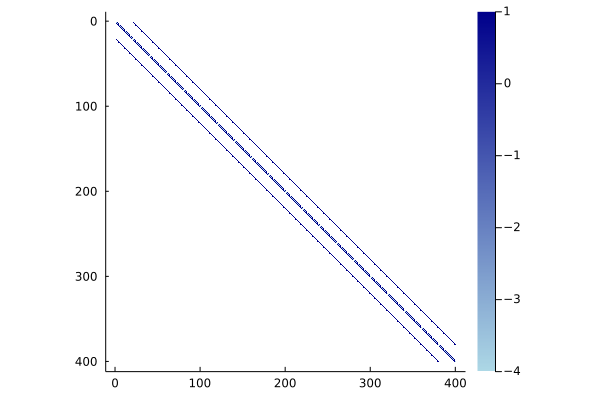

In [39]:
spy(L, seriescolor = :blues)

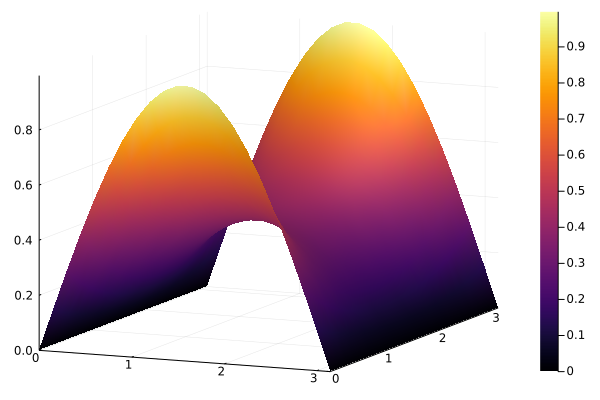

In [40]:
surface(x, y, Z')